1. Look at the dataset
    - Different sizes of images
    - Samples with wrong labels
    - Different backgrounds
    - File formats
    - Intensity range
    - Class distribution
2. Pre-process the data
    - Padded the images so they are square
    - Resized the images to a managable size
3. Experimental setup
    -   Single train/val/test split: 70%/ 15%/ 15%
    -   Set data augmentation
    -   Create data loaders
4. Transfer learning
    - SOTA models on imagenet
    - Add and train new top/predictor
    - Fine-tune all or some feature learning layers 
5. Loss and metrics
    -   Loss: categorical cross-entropy
    -   Metrics: Accuracy, sensitivity, specificity, confusion matrix, training and inference time?
6. Set your callbacks and track your experiments
    - Early stopping - patience
    - Model check point
    - Learning rate scheduler
    - Weights and biases (train/val loss)
7. Set your main hyperparameters
    - batch size
    - learning rate
    - number of epochs
8. Train 
    - Train your model
    - Need to write your training code in pure Python and PyTorch or use another library like lightning or ignite
9. Test 
    - Run prediction on your test set
    - Extract relevant metrics
    - Measure inference time

- Other suggestions:
    - Use config files to make experimenting different configs easily
    - Design locally, but run experiments in the cluster



In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

cpu


In [2]:
class TorchVisionDataset(Dataset):
    def __init__(self,data_dic, transform = None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    
    def __getitem__(self,idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        #lazily open image
        image = Image.open(file_path)

        #convert to rgb
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label
        


In [3]:

# # Python 3 code to rename multiple
# # files in a directory or folder
 
# # importing os module
# import os
 
# # Function to rename multiple files
# def main():
   
#     folder = "/content/drive/MyDrive/ENSF645_Assign2/severe"
#     for count, filename in enumerate(os.listdir(folder)):
#         dst = f"image_severe {str(count)}.jpg"
#         src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
#         dst =f"{folder}/{dst}"
         
#         # rename() function will
#         # rename all the files
#         os.rename(src, dst)
 
# # Driver Code
# if __name__ == '__main__':
     
#     # Calling main() function
#     main()

In [9]:
images = glob.glob("images/*/*")
images = np.array(images)
labels = np.array([f.split("\\")[-2] for f in images])
print(len(images))
print(labels.size)
print(images[0])
print(labels[0])


115
115
images\mild\1 (1).png
mild


In [10]:
classes = np.unique(labels).flatten()
print(classes)
labels_int = np.zeros(labels.size, dtype = np.int64)
print(labels_int.shape)
for ii,jj in enumerate(classes):
    labels_int[labels == jj] = ii 

['mild' 'moderate' 'normal' 'severe']
(115,)


In [13]:
for i in range(4):
    print("Label", i, ":", (labels_int == i).sum())

Label 0 : 29
Label 1 : 43
Label 2 : 20
Label 3 : 23


In [14]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=10)
sss.get_n_splits(images,labels_int)
dev_index, test_index = next(sss.split(images,labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index] 

In [15]:
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=10)
sss2.get_n_splits(dev_images,dev_labels)
train_index, val_index = next(sss2.split(dev_images,dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index] 

In [16]:
print("Train set:", train_images.size)
print("Val set:", val_images.size)
print("Test set:", test_images.size)


Train set: 73
Val set: 19
Test set: 23


In [17]:
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

In [18]:
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(mean = [0.4120, 0.3768, 0.3407],std = [0.2944,0.2759,0.2598])])


torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(mean = [0.4120, 0.3768, 0.3407],std = [0.2944,0.2759,0.2598])])

In [19]:
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

In [20]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size= 32, num_workers= 0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, num_workers= 0)

In [21]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [22]:
print(get_dataset_stats(trainloader))

(tensor([0.5573, 0.4841, 0.5525]), tensor([0.7225, 0.6746, 0.7154]))


In [24]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [25]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


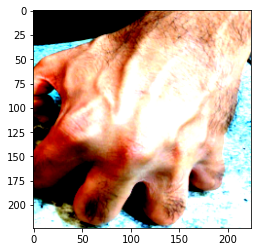

In [33]:
plt.figure()
plt.imshow(train_batch[0].numpy()[1].transpose(1,2,0))
plt.show()

In [45]:
class Model(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # transfer learning if pretrained=True
        self.feature_extractor = models.resnet18(weights=('DEFAULT' if transfer else None))

        if self.transfer:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       
       return x


In [46]:
net = Model(4, (3,224,224), False)
net.to(device)

Model(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [47]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [48]:
nepochs = 20
PATH = './EV_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / (i+1):.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i+1):.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

1,  train loss: 2.223, val loss: 1.392
Saving model
2,  train loss: 1.680, val loss: 1.049
Saving model
3,  train loss: 0.857, val loss: 0.668
Saving model
4,  train loss: 1.004, val loss: 0.826
5,  train loss: 0.751, val loss: 1.092
6,  train loss: 0.886, val loss: 1.025
7,  train loss: 0.764, val loss: 0.629
Saving model
8,  train loss: 0.633, val loss: 0.695
9,  train loss: 0.819, val loss: 0.879
10,  train loss: 0.585, val loss: 0.932
11,  train loss: 0.658, val loss: 0.625
Saving model
12,  train loss: 0.638, val loss: 0.697
13,  train loss: 0.637, val loss: 0.998
14,  train loss: 0.520, val loss: 1.133
15,  train loss: 0.574, val loss: 1.056
16,  train loss: 0.470, val loss: 0.875
17,  train loss: 0.413, val loss: 0.845
18,  train loss: 0.564, val loss: 0.913
19,  train loss: 0.381, val loss: 0.851
20,  train loss: 0.397, val loss: 0.933
Finished Training


In [49]:
# Load the best model to be used in the test set
net = Model(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [50]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 69.56521739130434 %
